# Bootstrap vs Classical Estimation — Notebook

This notebook contains the full code for the project: implementations of classical and bootstrap confidence intervals, a simulation engine, and a real-data case study using the provided diabetes dataset.

Sections:

1. Setup & imports
2. Load dataset & EDA
3. CI implementations (classical, percentile, studentized, BCa)
4. Real-data small-sample analysis (example: BMI)
5. Simulation engine (demo run)
6. Saving results & figures

Run cells sequentially. For heavy simulation runs, increase R/B as desired (note computational cost).

In [11]:
# 1) Setup & imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm
import scipy
import os
os.makedirs("Math333 project/figures", exist_ok=True)


print('numpy', np.__version__, 'pandas', pd.__version__)


numpy 1.26.4 pandas 2.2.2


In [12]:
# 2) Load dataset
path = ('/Users/madisongrace/Downloads/diabetes_012_health_indicators_BRFSS2015.csv')
if not os.path.exists(path):
    raise FileNotFoundError(f"Dataset not found at {path}. Make sure the file was uploaded.")
df = pd.read_csv(path)
print('shape:', df.shape)
df.head()


shape: (253680, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


numeric columns: ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
BMI summary:


count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64

Saved Math333 project/figures/BMI_hist_full.png


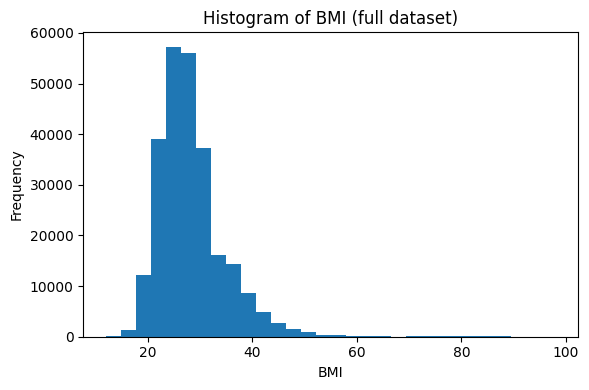

In [13]:
# Quick EDA: distribution of BMI (if present), and list of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('numeric columns:', numeric_cols[:30])

# Create directory for saving figures
import os
os.makedirs("Math333 project/figures", exist_ok=True)

if 'BMI' in df.columns:
    print('BMI summary:')
    display(df['BMI'].describe())
    plt.figure(figsize=(6,4))
    plt.hist(df['BMI'].dropna(), bins=30)
    plt.title('Histogram of BMI (full dataset)')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig("Math333 project/figures/BMI_hist_full.png")
    print("Saved Math333 project/figures/BMI_hist_full.png")



In [14]:
# 3) CI implementations: classical t-CI, percentile bootstrap, studentized bootstrap, BCa
import numpy as np
from scipy.stats import t, norm
import scipy

def classical_ci_mean(x, alpha=0.05):
    x = np.asarray(x)[~np.isnan(x)]
    n = len(x)
    mean = np.mean(x)
    se = np.std(x, ddof=1) / np.sqrt(n)
    tcrit = t.ppf(1 - alpha/2, df=n-1)
    return mean, mean - tcrit*se, mean + tcrit*se, se

def bootstrap_percentile_ci(x, B=2000, alpha=0.05, rng=None):
    x = np.asarray(x)[~np.isnan(x)]
    n = len(x)
    if rng is None:
        rng = np.random.default_rng()
    idx = rng.integers(0, n, size=(B, n))
    samples = x[idx]
    theta_boot = samples.mean(axis=1)
    lower = np.quantile(theta_boot, alpha/2)
    upper = np.quantile(theta_boot, 1-alpha/2)
    return np.mean(x), lower, upper, np.std(theta_boot, ddof=1)

def bootstrap_t_ci(x, B=2000, alpha=0.05, rng=None):
    x = np.asarray(x)[~np.isnan(x)]
    n = len(x)
    if rng is None:
        rng = np.random.default_rng()
    theta_hat = np.mean(x)
    t_stats = []
    for _ in range(B):
        xb = rng.choice(x, size=n, replace=True)
        tb = (np.mean(xb) - theta_hat) / (np.std(xb, ddof=1)/np.sqrt(n))
        t_stats.append(tb)
    t_stats = np.array(t_stats)
    lower_t = np.quantile(t_stats, 1 - alpha/2)
    upper_t = np.quantile(t_stats, alpha/2)
    se = np.std(x, ddof=1)/np.sqrt(n)
    return theta_hat, theta_hat - lower_t*se, theta_hat - upper_t*se, se

def bootstrap_bca_ci(x, B=2000, alpha=0.05, rng=None):
    # BCa implementation for mean
    x = np.asarray(x)[~np.isnan(x)]
    n = len(x)
    if rng is None:
        rng = np.random.default_rng()
    theta_hat = np.mean(x)
    # bootstrap estimates
    idx = rng.integers(0, n, size=(B, n))
    samples = x[idx]
    theta_boot = samples.mean(axis=1)
    # bias-correction z0
    prop_less = np.sum(theta_boot < theta_hat) / B
    z0 = norm.ppf(prop_less) if prop_less not in [0,1] else (norm.ppf(1e-10) if prop_less==0 else norm.ppf(1-1e-10))
    # jackknife for acceleration
    jack = np.array([np.mean(np.delete(x, i)) for i in range(n)])
    jack_mean = np.mean(jack)
    num = np.sum((jack_mean - jack)**3)
    den = 6.0 * (np.sum((jack_mean - jack)**2)**1.5)
    acc = num/den if den != 0 else 0.0
    alpha1 = norm.cdf(z0 + (z0 + norm.ppf(alpha/2)) / (1 - acc*(z0 + norm.ppf(alpha/2))))
    alpha2 = norm.cdf(z0 + (z0 + norm.ppf(1-alpha/2)) / (1 - acc*(z0 + norm.ppf(1-alpha/2))))
    lower = np.quantile(theta_boot, alpha1)
    upper = np.quantile(theta_boot, alpha2)
    return theta_hat, lower, upper, np.std(theta_boot, ddof=1)


Small sample (n=20) summary: mean, sd
27.35 4.498830257323623

Classical t-CI: (mean, lower, upper, se)
(27.35, 25.244482627534758, 29.455517372465245, 1.005969027460849)

Bootstrap percentile CI: (mean, lower, upper, boot_sd)
(27.35, 25.45, 29.3, 0.9880503636634965)

Bootstrap t CI: (mean, lower, upper, se)
(27.35, 25.331276471399917, 29.505433599637108, 1.005969027460849)

BCa CI: (mean, lower, upper, boot_sd)
(27.35, 25.45, 29.15, 0.9604478265443454)
Saved figures/BMI_hist_small_n20.png


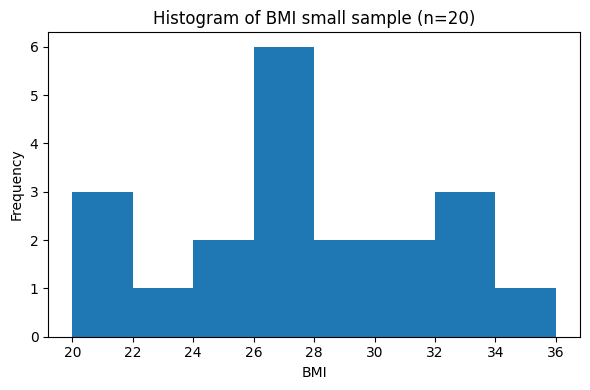

In [16]:
# 4) Real-data small-sample analysis (example using BMI)
rng = np.random.default_rng(42)
if 'BMI' not in df.columns:
    print('BMI not in dataset; pick another numeric column. Numeric columns:', df.select_dtypes(include=[np.number]).columns.tolist())
else:
    # take small sample n=20
    small_sample = df['BMI'].dropna().sample(n=20, random_state=42).values
    print('Small sample (n=20) summary: mean, sd')
    print(np.mean(small_sample), np.std(small_sample, ddof=1))
    print('\nClassical t-CI: (mean, lower, upper, se)')
    print(classical_ci_mean(small_sample))
    print('\nBootstrap percentile CI: (mean, lower, upper, boot_sd)')
    print(bootstrap_percentile_ci(small_sample, B=2000, rng=rng))
    print('\nBootstrap t CI: (mean, lower, upper, se)')
    print(bootstrap_t_ci(small_sample, B=2000, rng=rng))
    print('\nBCa CI: (mean, lower, upper, boot_sd)')
    print(bootstrap_bca_ci(small_sample, B=2000, rng=rng))
    # histogram of small sample
    plt.figure(figsize=(6,4))
    plt.hist(small_sample, bins=8)
    plt.title('Histogram of BMI small sample (n=20)')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig("figures/BMI_hist_small_n20.png")
    print("Saved figures/BMI_hist_small_n20.png")

In [19]:
# 5) Simulation engine (demo). For full experiment, increase R (e.g., 5000) and B (e.g., 2000).
import time
import os
os.makedirs("results", exist_ok=True)


def run_demo_simulation(R=200, B=500, seed=123):
    rng = np.random.default_rng(seed)
    results = []
    def normal_dgp(n): return rng.normal(0,1,size=n)
    def lognorm_dgp(n): return rng.lognormal(mean=0, sigma=1, size=n)
    def t3_dgp(n): return scipy.stats.t(df=3).rvs(size=n, random_state=seed)
    def mixture_dgp(n):
        u = rng.random(n)
        return np.where(u<0.9, rng.normal(0,1,size=n), rng.normal(5,1,size=n))

    DGPs = [('Normal', normal_dgp, 0.0),
            ('Lognormal', lognorm_dgp, np.exp(0.5)),
            ('t3', t3_dgp, 0.0),
            ('Mixture', mixture_dgp, 0.5)]
    ns = [8,12,20,30]
    for name, dgp, true_mean in DGPs:
        for n in ns:
            cover_c = []
            cover_p = []
            cover_t = []
            widths_c = []
            widths_p = []
            widths_t = []
            start=time.time()
            for i in range(R):
                x = dgp(n)
                theta_hat, lc, uc, se = classical_ci_mean(x)
                _, lp, up, _ = bootstrap_percentile_ci(x, B=B, rng=rng)
                _, lt, ut, _ = bootstrap_t_ci(x, B=B, rng=rng)
                cover_c.append(1 if (lc<=true_mean<=uc) else 0)
                cover_p.append(1 if (lp<=true_mean<=up) else 0)
                cover_t.append(1 if (lt<=true_mean<=ut) else 0)
                widths_c.append(uc-lc)
                widths_p.append(up-lp)
                widths_t.append(ut-lt)
            elapsed=time.time()-start
            results.append({
                'dgp': name, 'n': n,
                'cover_classical': np.mean(cover_c),
                'cover_perc': np.mean(cover_p),
                'cover_t': np.mean(cover_t),
                'w_classical': np.mean(widths_c),
                'w_perc': np.mean(widths_p),
                'w_t': np.mean(widths_t),
                'time_sec': elapsed
            })
            print(f'Completed {name} n={n} in {elapsed:.1f}s')
    return pd.DataFrame(results)

# run a quick demo simulation
sim_demo = run_demo_simulation(R=200, B=500, seed=42)
sim_demo.to_csv("results/simulation_demo_results.csv", index=False)
print("Saved results/simulation_demo_results.csv")
sim_demo.head()


Completed Normal n=8 in 2.1s
Completed Normal n=12 in 2.1s
Completed Normal n=20 in 2.2s
Completed Normal n=30 in 2.2s
Completed Lognormal n=8 in 2.1s
Completed Lognormal n=12 in 2.1s
Completed Lognormal n=20 in 2.1s
Completed Lognormal n=30 in 2.1s
Completed t3 n=8 in 2.2s
Completed t3 n=12 in 2.2s
Completed t3 n=20 in 2.2s
Completed t3 n=30 in 2.3s
Completed Mixture n=8 in 2.1s
Completed Mixture n=12 in 2.1s
Completed Mixture n=20 in 2.1s
Completed Mixture n=30 in 2.1s
Saved results/simulation_demo_results.csv


,dgp,n,cover_classical,cover_perc,cover_t,w_classical,w_perc,w_t,time_sec
0,Normal,8,0.945,0.885,0.945,1.612786,1.235108,1.735786,2.144420
1,Normal,12,0.955,0.900,0.955,1.219113,1.028803,1.278970,2.139256
2,Normal,20,0.955,0.920,0.945,0.931141,0.840605,0.938113,2.175228
3,Normal,30,0.975,0.965,0.970,0.733363,0.682903,0.730281,2.184282
4,Lognormal,8,0.835,0.765,0.915,2.663702,1.976696,6.123565,2.146049


Saved results/coverage_plots/coverage_Normal_demo.png
Saved results/coverage_plots/coverage_Lognormal_demo.png
Saved results/coverage_plots/coverage_t3_demo.png
Saved results/coverage_plots/coverage_Mixture_demo.png


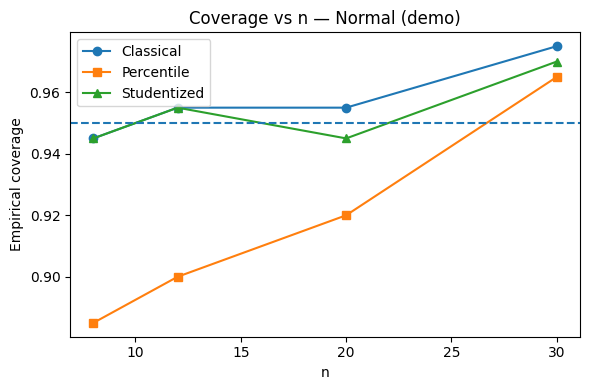

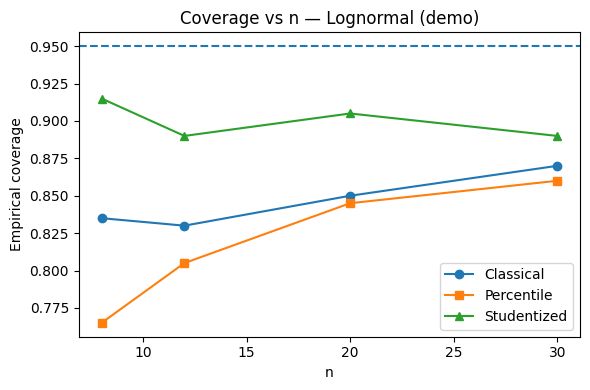

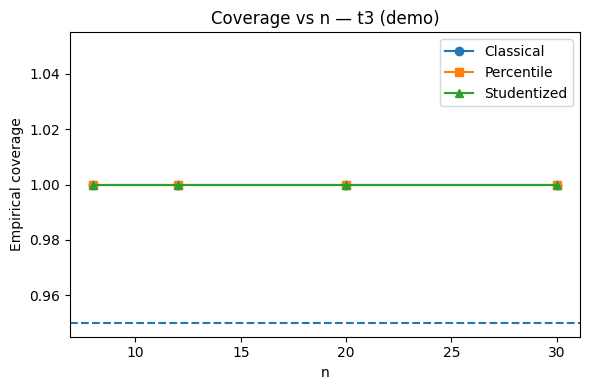

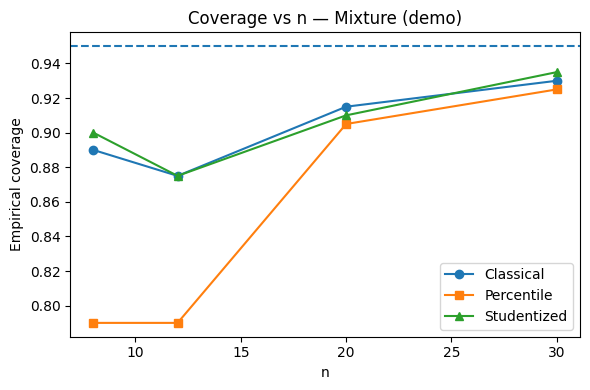

In [21]:
# 6) Plot demo results: coverage vs n for each method and DGP
import matplotlib.pyplot as plt
import os
import pandas as pd


# ⚠️ Load from local 'results/' folder (NOT /mnt/data/)
sim = pd.read_csv("results/simulation_demo_results.csv")

# Create output directory for plots
os.makedirs("results/coverage_plots", exist_ok=True)

for dgp in sim['dgp'].unique():
    subset = sim[sim['dgp']==dgp]
    plt.figure(figsize=(6,4))
    plt.plot(subset['n'], subset['cover_classical'], marker='o', label='Classical')
    plt.plot(subset['n'], subset['cover_perc'], marker='s', label='Percentile')
    plt.plot(subset['n'], subset['cover_t'], marker='^', label='Studentized')
    plt.axhline(0.95, linestyle='--')
    plt.xlabel('n')
    plt.ylabel('Empirical coverage')
    plt.title(f'Coverage vs n — {dgp} (demo)')
    plt.legend()
    plt.tight_layout()
    fname = f"results/coverage_plots/coverage_{dgp}_demo.png"
    plt.savefig(fname)
    print('Saved', fname)
